In [1]:
#Importação de bibliotecas
import torch
import glob
import os
import pathlib
import cv2
import shutil
import random

import numpy                as np
import pandas               as pd
import matplotlib.pyplot    as plt
import cv2                  as cv 
import matplotlib.pyplot    as plt
import torch.nn.functional  as F
import seaborn              as sns
import plotly.express       as px
import plotly.graph_objects as go

from random                  import sample
from plotly.subplots         import make_subplots
from google.colab            import drive
from google.colab.patches    import cv2_imshow
from skimage                 import io
from PIL                     import Image
from torch                   import nn, optim
from torchvision             import datasets, transforms
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("Versão:",torch.__version__)

Versão: 1.10.0+cu111


In [2]:
#Leituras de arquivo do drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Modelo de arquitetura da CNN
'''class classificador(nn.Module):
    def __init__ (self):
        super().__init__()
      
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10, stride=(1,1), padding=(0,0))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=(1,1), padding=(2,2))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=(1,1), padding=(2,2))

        self.activation = nn.ReLU() 
        self.bnorm = nn.BatchNorm2d(num_features=64)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(in_features=16384, out_features=256)
        self.linear2 = nn.Linear(in_features=256, out_features=128)
        self.output = nn.Linear(in_features=128, out_features=4)

        self.dropout1 = nn.Dropout(p = 0.1)
        self.dropout2 = nn.Dropout(p = 0.2)
        
    def forward(self, X):
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.dropout1(self.pool(self.activation(self.conv2(X))))
        X = self.dropout2(self.pool(self.activation(self.conv3(X))))
        X = self.flatten(X)
        
        X = self.activation(self.linear1(X))
        X = self.activation(self.linear2(X))
        X = self.output(X)
        
        return X'''

'class classificador(nn.Module):\n    def __init__ (self):\n        super().__init__()\n      \n        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10, stride=(1,1), padding=(0,0))\n        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=(1,1), padding=(2,2))\n        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=(1,1), padding=(2,2))\n\n        self.activation = nn.ReLU() \n        self.bnorm = nn.BatchNorm2d(num_features=64)\n        self.pool = nn.MaxPool2d(kernel_size=(2,2))\n        \n        self.flatten = nn.Flatten()\n        \n        self.linear1 = nn.Linear(in_features=16384, out_features=256)\n        self.linear2 = nn.Linear(in_features=256, out_features=128)\n        self.output = nn.Linear(in_features=128, out_features=4)\n\n        self.dropout1 = nn.Dropout(p = 0.1)\n        self.dropout2 = nn.Dropout(p = 0.2)\n        \n    def forward(self, X):\n        X = self.pool(self.bnorm(self.

In [4]:
#Modelo de arquitetura da CNN
class classificador(nn.Module):
    def __init__ (self):
        super().__init__()
      
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10, stride=(1,1), padding=(0,0))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=(1,1), padding=(2,2))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=(1,1), padding=(2,2))

        self.activation = nn.ReLU() 
        self.bnorm = nn.BatchNorm2d(num_features=64)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(in_features=16384, out_features=128)
        self.output = nn.Linear(in_features=128, out_features=4)

        self.dropout1 = nn.Dropout(p = 0.1)
        self.dropout2 = nn.Dropout(p = 0.2)
        
    def forward(self, X):
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.dropout1(self.pool(self.activation(self.conv2(X))))
        X = self.dropout2(self.pool(self.activation(self.conv3(X))))
        X = self.flatten(X)
        
        X = self.activation(self.linear1(X))
        X = self.output(X)
        
        return X

In [5]:
path_train = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/80_20_Brain_Tumor/BrainTumor_80/'
path_test = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/80_20_Brain_Tumor/BrainTumor_20/'

In [6]:
from torchvision.transforms.transforms import RandomHorizontalFlip
transform_train = transforms.Compose(
    [
     transforms.Resize([128,128]),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(45),
     transforms.ToTensor()
    ]
)

transform_test = transforms.Compose(
    [
     transforms.Resize([128,128]),
     transforms.ToTensor()
    ]
)

In [7]:
train_dataset = datasets.ImageFolder(path_train, transform=transform_train)
test_dataset = datasets.ImageFolder(path_test, transform=transform_test)

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [9]:
def get_class_distribution(dataset_obj):
  count_dict = {k:0 for k, v in dataset_obj.class_to_idx.items()}
  for i in dataset_obj:
    y_labels = i[1]
    y_labels = idx2class[y_labels]
    count_dict[y_labels] += 1
  return count_dict

idx2class = {v: k for k, v in train_dataset.class_to_idx.items()}
df_treino = pd.DataFrame.from_dict([get_class_distribution(train_dataset)]).melt()

idx2class = {v: k for k, v in test_dataset.class_to_idx.items()}
df_teste = pd.DataFrame.from_dict([get_class_distribution(test_dataset)]).melt()

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(
    labels=df_treino['variable'],
     values=df_treino['value'],
      pull=[0, 0, 0.1, 0]),
       1, 1)

fig.add_trace(go.Pie(
    labels=df_teste['variable'],
     values=df_teste['value'],
      pull=[0, 0, 0.1, 0]),
       1, 2)

fig.update_traces(hole=.4,
    hoverinfo='label+percent',
                  textinfo='value',
                  textfont_size=12.5,
                  marker=dict(
                      line=dict(
                          color='#000000',
                           width=1)
                      )
                  )

fig.update_layout(
    title_text = 'Proporção da base de dados de treino e teste',
    annotations=[dict(text='Treino', x=0.181, y=0.5, font_size=20, showarrow=False),
                 dict(text='Teste', x=0.80, y=0.5, font_size=20, showarrow=False)]
)

fig.show()

In [10]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [11]:
#Setamos a GPU necessária para realizar nossa classificação
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
print(device)

net.to(device)

cuda


classificador(
  (conv1): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (activation): ReLU()
  (bnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=16384, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=4, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [12]:
loss_values = []
accu_values = []
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    for i, data in enumerate(loader):
        
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        #loss_values.append(running_loss / len(train_dataset))
        
        ps = F.softmax(outputs, dim=1)
        top_p, top_class = ps.topk(k=1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        
        accuracy= torch.mean(equals.type(torch.float))
        
        running_accuracy += accuracy
        
        #Imprimir os dados referentes a este loop
        print("Época {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}".format(epoch + 1, i+1, len(loader)\
                                                                                             , loss, accuracy), end= '\r')
    #Impressão referente à épocas
    print("Época {:3d} Finalizada: perda {:.5f} - precisão {:.5f}".format(epoch+1, running_loss/len(loader)\
                                                                         ,running_accuracy/len(loader)))
    loss_values.append(running_loss / len(loader))
    accu_values.append(running_accuracy/len(loader))

In [13]:
loss_train = [item for item in loss_values]
accu_train = [item for item in accu_values]

In [14]:
for epoch in range(100):
    print("Treinando...")
    training_loop(train_loader, epoch)
    net.eval()
    net.train()

Treinando...
Época   1 Finalizada: perda 1.34190 - precisão 0.35938
Treinando...
Época   2 Finalizada: perda 1.25743 - precisão 0.52000
Treinando...
Época   3 Finalizada: perda 1.17917 - precisão 0.55812
Treinando...
Época   4 Finalizada: perda 1.10332 - precisão 0.57937
Treinando...
Época   5 Finalizada: perda 1.04166 - precisão 0.61375
Treinando...
Época   6 Finalizada: perda 0.99323 - precisão 0.62187
Treinando...
Época   7 Finalizada: perda 0.94628 - precisão 0.63313
Treinando...
Época   8 Finalizada: perda 0.91759 - precisão 0.64937
Treinando...
Época   9 Finalizada: perda 0.88797 - precisão 0.66000
Treinando...
Época  10 Finalizada: perda 0.87512 - precisão 0.64625
Treinando...
Época  11 Finalizada: perda 0.84966 - precisão 0.66688
Treinando...
Época  12 Finalizada: perda 0.83184 - precisão 0.66438
Treinando...
Época  13 Finalizada: perda 0.80905 - precisão 0.66875
Treinando...
Época  14 Finalizada: perda 0.80465 - precisão 0.68125
Treinando...
Época  15 Finalizada: perda 0.79844

In [15]:
loss_train = [item for item in loss_values]
accu_train = [item for item in accu_values]
print(len(loss_train), len(accu_train))

100 100


In [16]:
accu_values.clear()
loss_values.clear()
for epoch in range(100):
    net.eval()
    print("Validando...")
    training_loop(test_loader, epoch)
    net.train()

Validando...
Época   1 Finalizada: perda 1.16450 - precisão 0.59573
Validando...
Época   2 Finalizada: perda 0.87661 - precisão 0.65774
Validando...
Época   3 Finalizada: perda 0.82175 - precisão 0.66171
Validando...
Época   4 Finalizada: perda 0.75664 - precisão 0.68750
Validando...
Época   5 Finalizada: perda 0.72247 - precisão 0.69196
Validando...
Época   6 Finalizada: perda 0.69627 - precisão 0.72024
Validando...
Época   7 Finalizada: perda 0.66523 - precisão 0.73115
Validando...
Época   8 Finalizada: perda 0.63437 - precisão 0.74752
Validando...
Época   9 Finalizada: perda 0.60900 - precisão 0.76190
Validando...
Época  10 Finalizada: perda 0.57850 - precisão 0.77728
Validando...
Época  11 Finalizada: perda 0.55805 - precisão 0.76835
Validando...
Época  12 Finalizada: perda 0.55111 - precisão 0.78522
Validando...
Época  13 Finalizada: perda 0.53132 - precisão 0.78869
Validando...
Época  14 Finalizada: perda 0.50817 - precisão 0.81696
Validando...
Época  15 Finalizada: perda 0.49884

In [17]:
loss_test = [item for item in loss_values]
accu_test = [item for item in accu_values]

In [18]:
print(len(loss_test), len(accu_test))

100 100


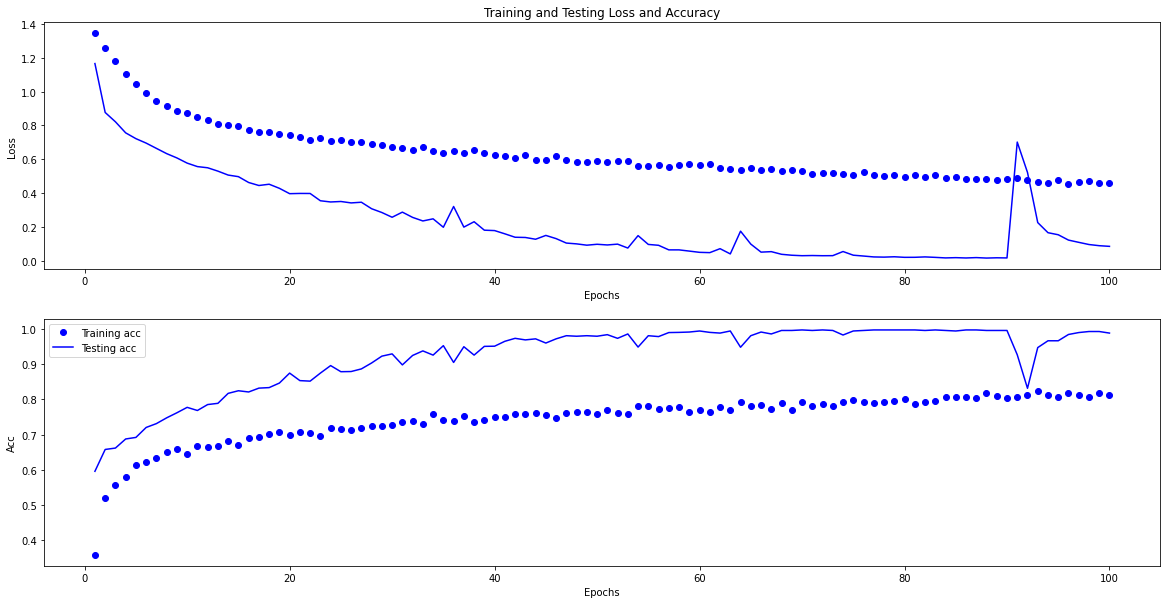

In [24]:
epochs_x = range(1, len(loss_test) + 1)
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_train, 'bo', label='Training loss')
plt.plot(epochs_x, loss_test, 'b', label='Testing loss')
plt.title('Training and Testing Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(2,1,2)
plt.plot(epochs_x, accu_train, 'bo', label='Training acc')
plt.plot(epochs_x, accu_test, 'b', label='Testing acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [20]:
numero_de_classes = 4

matriz = torch.zeros(numero_de_classes, numero_de_classes)
with torch.no_grad():
  for i, (inputs, classes) in enumerate(test_loader):
    inputs = inputs.to(device)
    outputs = net(inputs)
    _, previsao = torch.max(outputs, 1)
    for k, l in zip(classes.view(-1), previsao.view(-1)):
      matriz[k.long(), l.long()] += 1

In [21]:
print(matriz)

tensor([[171.,   3.,   6.,   5.],
        [ 32., 142.,   8.,   5.],
        [  4.,   0.,  93.,   3.],
        [  4.,   0.,   0., 176.]])


In [22]:
print(matriz.diag()/matriz.sum(1))

tensor([0.9243, 0.7594, 0.9300, 0.9778])
